In [10]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from warnings import filterwarnings

# Task 3 - Regression 

## Load settings

In [13]:
grid = None
k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task3"
filedir = "/home/fredrik/Documents/Learning_systems/Labs/Project/"
#filedir = "C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/"

scoring='neg_mean_squared_error' # Scoring method for GridsearchCV
score_function = f_regression # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [8]:
# GridSearchCV
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],
    },{
        'clf':[RandomForestRegressor(random_state=seed)],  
        'clf__n_estimators':[100,150,200],
        
    },{
        'clf':[MLPRegressor()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [4]:
filename = "datasets/powerTrainData.mat"

mat = loadmat(filename)
input_train = mat['powerTrainInput'].T

target_train = mat['powerTrainOutput'].reshape(len(input_train))
input_test = mat['powerTestInput'].T

## Data info

In [9]:
get_data_info(input_train, target_train)

Length of 844
X.shape: (844, 15) y.shape: (844,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [42]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

Length of input: 844


## Feature distribution

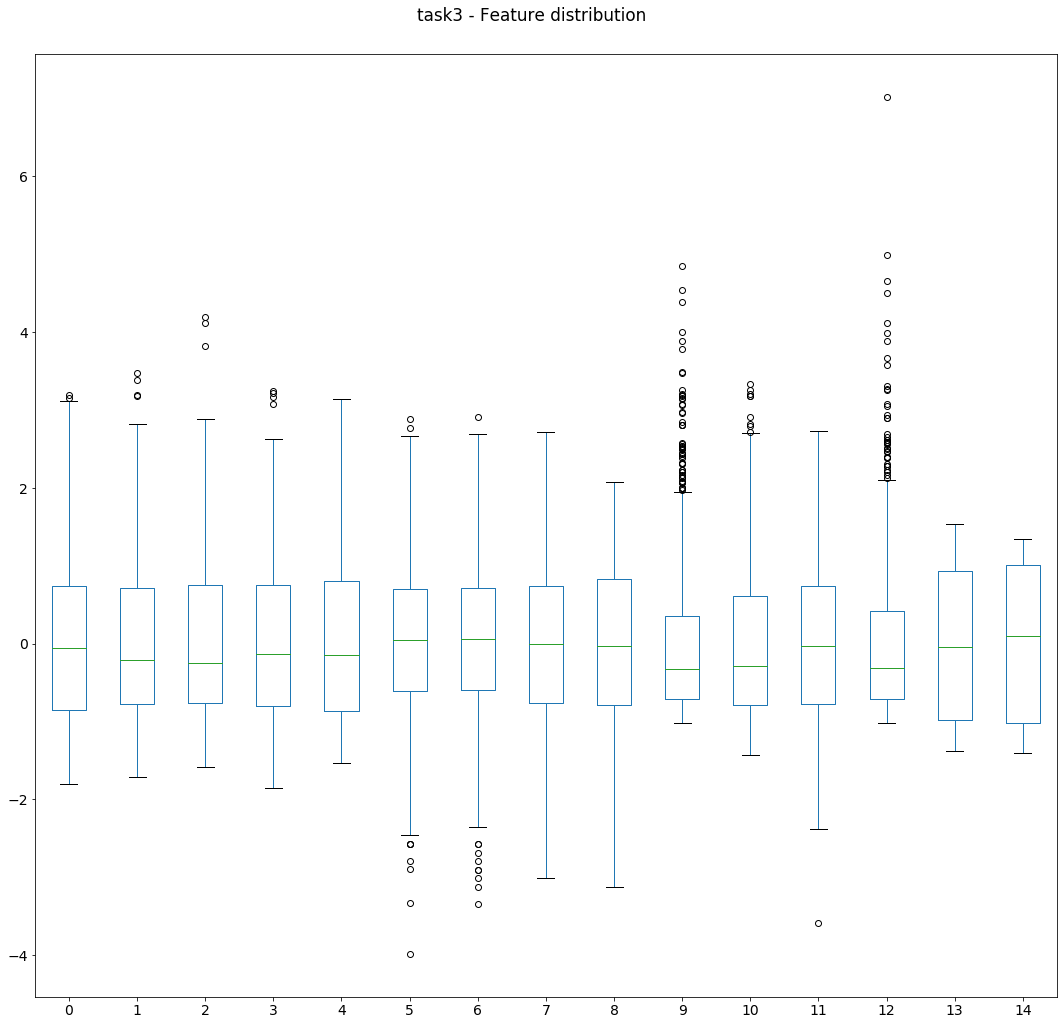

In [43]:
plot_feature_distribution(input_train, filedir=filedir, taskname=taskname)

## Feature reduction
Reduce dimensionality by PCA transform

In [44]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (844, 15)
transformed shape: (844, 6)
Explained variance: [0.71291343 0.08305948 0.06661705 0.04012179 0.03533515 0.02463563]


## Feature extraction

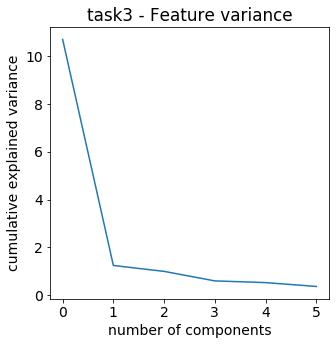

In [45]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Feature selection
Extract top features above depending on PCA

[ 0  1  2  3  4 11]
Shape of input: (844, 15)


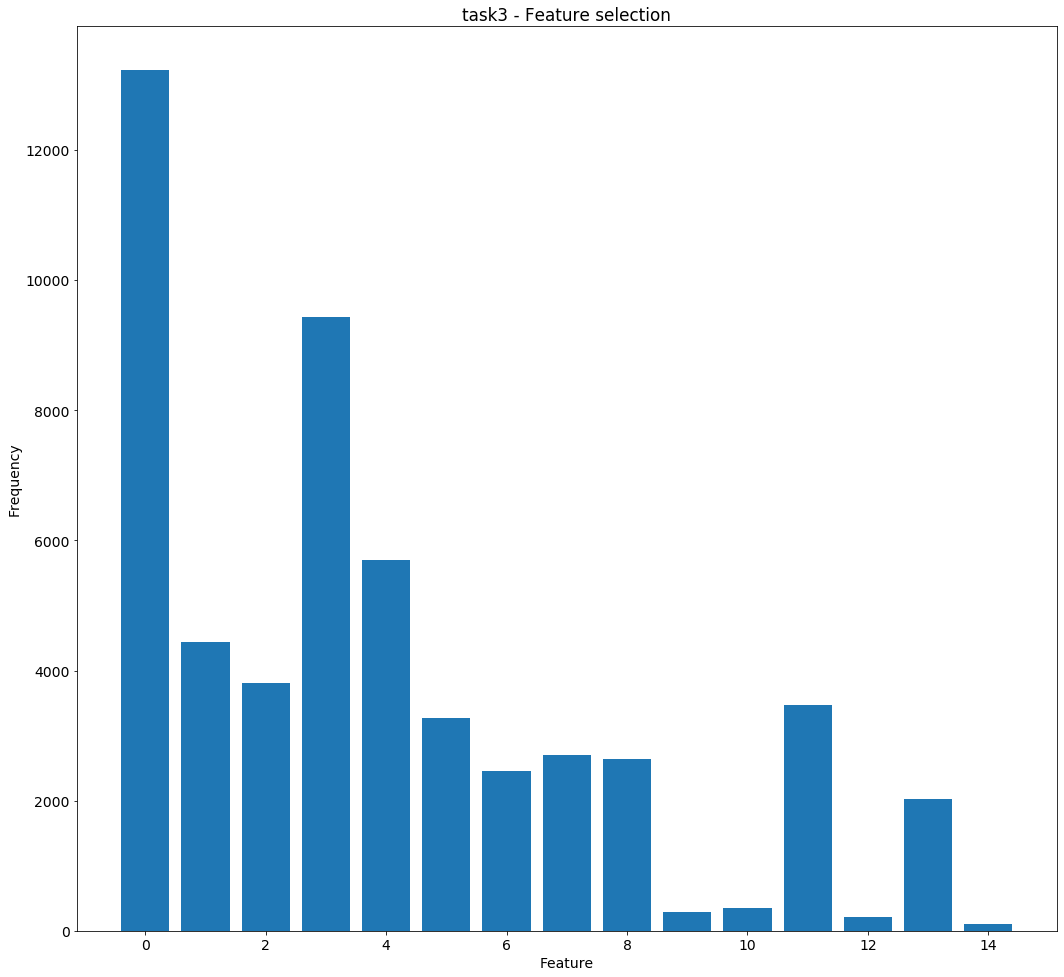

In [46]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname,feature_tot=feature_tot)

## Feature Relationship

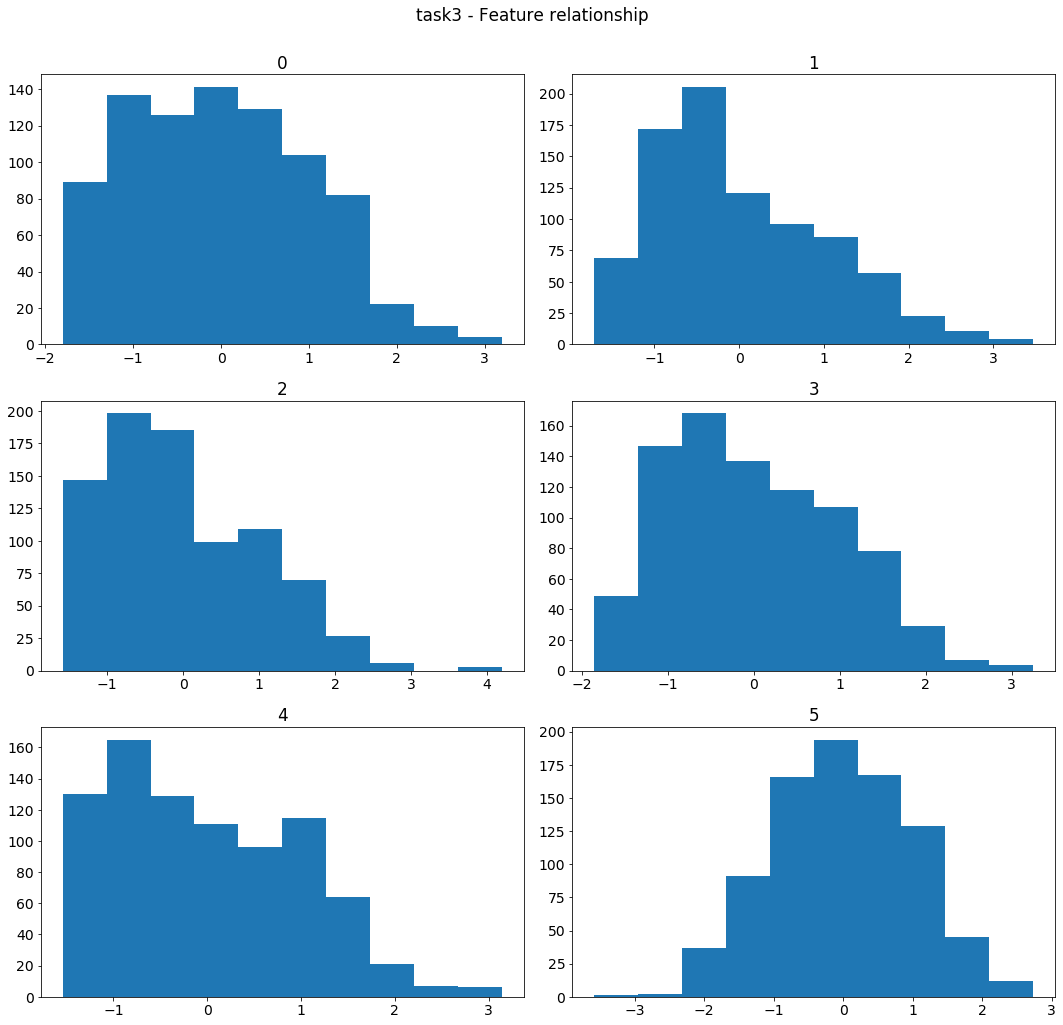

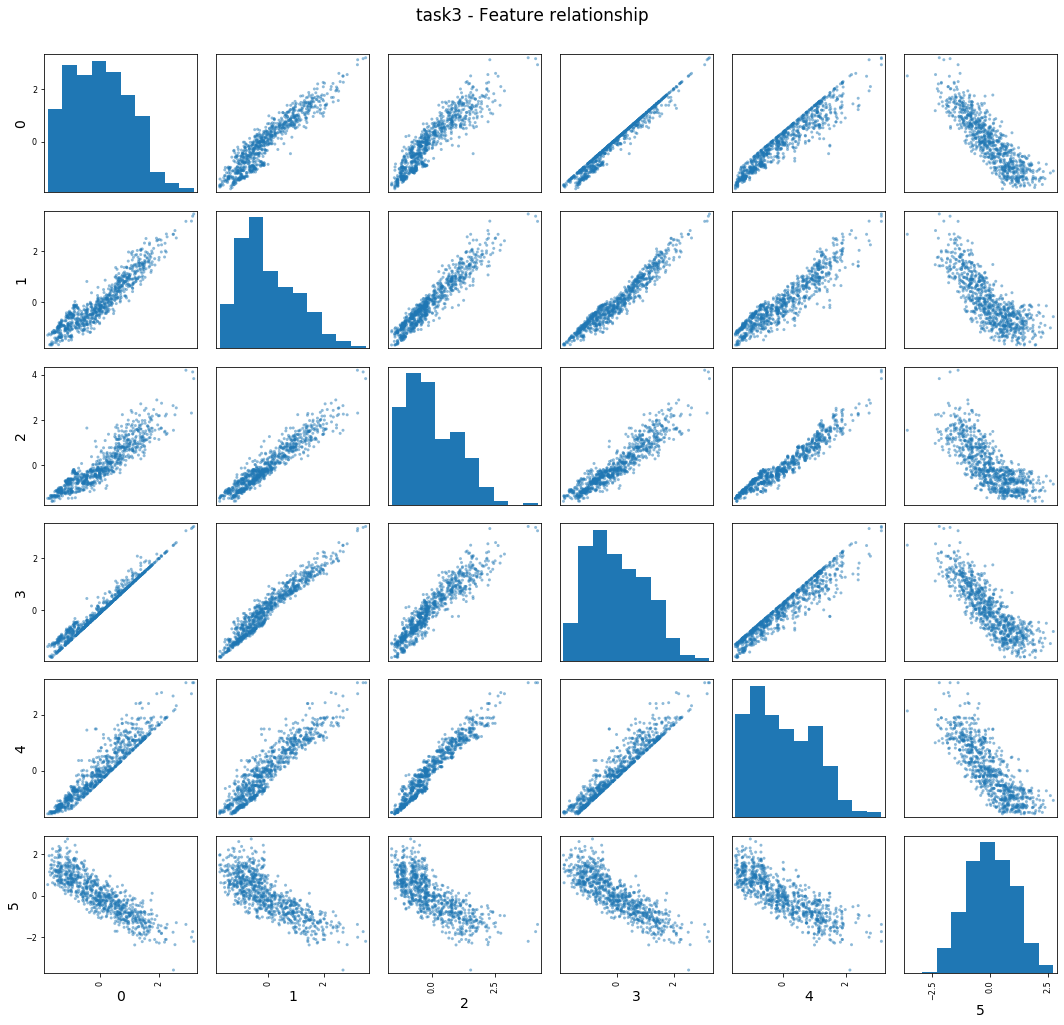

In [47]:
plot_feature_relationship(input_train_fs, filedir, taskname)

## Hyperparameter tuning

In [48]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 16.4min finished


## Save model

In [49]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_systems/Labs/Project/Models/task3.joblib


## Load model

In [14]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

Loading model:  /home/fredrik/Documents/Learning_systems/Labs/Project/Models/task3.joblib


## Get Model info

In [15]:
get_model_info(grid)

    mean_test_score  std_test_score  rank_test_score  \
39    -11098.585796     3237.846183                1   
47    -11287.191160     3550.459524                2   
35    -11293.641862     3326.795473                3   
51    -11300.521074     3407.391361                4   
43    -11351.467304     3334.428404                5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

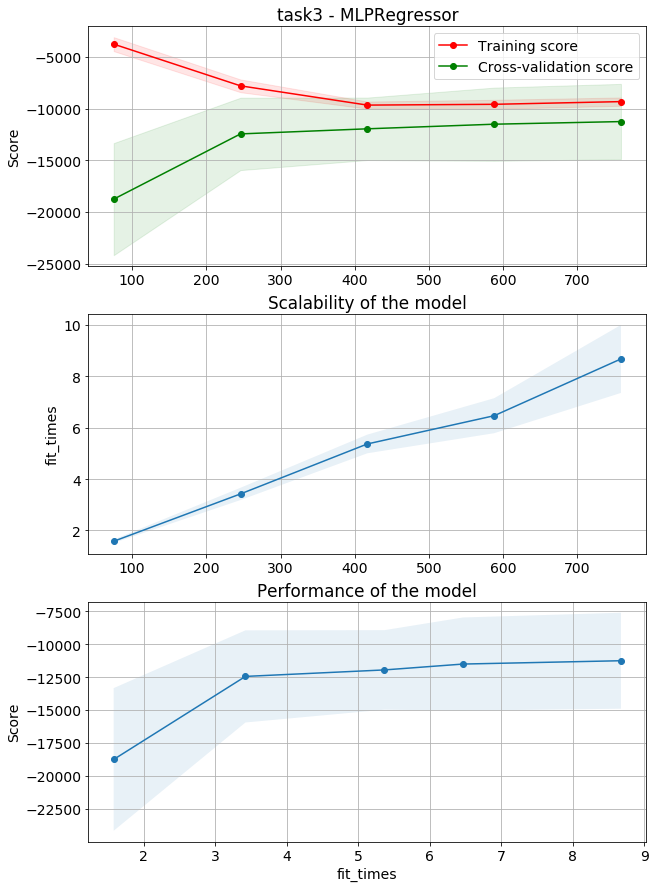

In [52]:
validate_curve(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname,scoring=scoring, k=k)

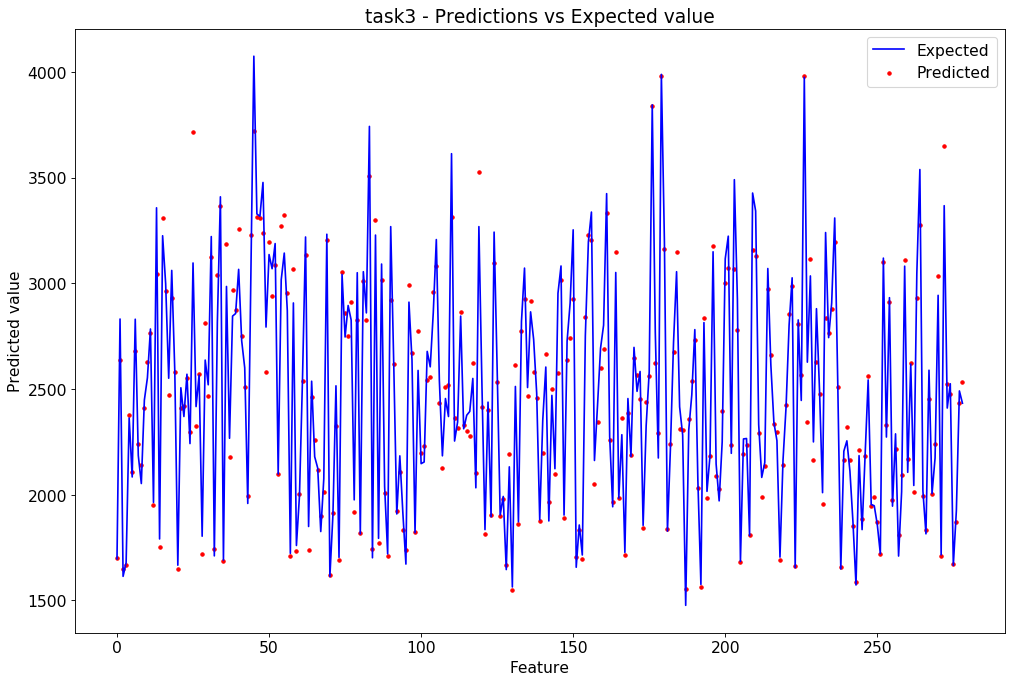

In [53]:
display_model_predict(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [54]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
save_prediction(predict, filedir, taskname)
print(predict)

[3206.73803521 3058.21980327 3217.66373018 3116.20483727 2871.78192806
 2509.64921621 2426.37885007 3389.08115909 3119.90103577 3287.57802356
 3232.85520898 3366.9439143  2935.83808041 2887.02009781 2465.25666198
 3117.95689891 3281.87884457 3203.42654773 2715.25234924 3299.6860344
 2863.48123354 3049.47859086 3232.87968872 3274.30034506 2981.86479838
 3168.52172969 3465.87972578 2376.78652728 3199.91686698 3273.91638089
 3629.04392938 2885.62845482 3098.43643006 3837.39416739 3435.15051686
 3078.867431   3369.55724888 2819.6316512  3102.78471952 2902.09134266
 2633.11087871 3457.38527487 3080.50049041 3357.36406899 3464.61889337
 3073.74710223 2520.11718534 2822.37622869 2874.97076189 2375.01079683
 3114.18312268 3574.81248643 3090.43615745 2478.48104732 2907.06221659
 3116.95032817 2613.63882527 3268.62279671 3428.91432107 3141.87952513
 3134.71502117 3625.75114208 2962.78928995 3117.61295832 3702.59184505
 3338.56524152 3220.98470712 3150.64235305 2952.86105933 3273.20137564
 2570.3